# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

_To reduce boilerplate, code for visualizations and transformations can be found in eda_modules.py_

## Abstract
Recommender systems are an often behind the scenes but rather foundational aspect of life today. Usually when we engage with media, we are engaging with a recommender: using social media, reading the news, buying something online and much more. Regardless of how ubiquitous recommenders are, evaluating and making them presents interesting and unique problems. Recommenders get gauged on several different metrics of accuracy: serendipity, novelty, robustness, accuracy and coverage to name a few. Through this project we aim to evaluate the performance of several recommender systems, frameworks and how we might improve them in the context of the Microsoft News Dataset. This report will be split into a couple main chapters, the first one below being exploratory data analysis. After walking through our analysis and preparation of the microsoft news dataset, we delve into recommender system frameworks, metrics and evalulation.

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions respectively. 

In [1]:
## IMPORTS ## REMOVE IMPORTS NOT EDA_MODULES ONCE DONE ##
import ExploratoryAnalysis.visualization_modules as visualization_modules # contains all custom modules for EDA on MIND
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as datetime


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

In [2]:
news = pd.read_csv('../MIND_small/csv/news.csv')
news.head(2)

,Unnamed: 0,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


## Starting with news
As noticeable above, there are columns for categories and subcategories. As these categories will be utilized to improve recommendations we will start our analysis of the news dataset by taking a quick peak at how many categories there may be, and what sorts of sub-categories we'll find in each via a treemap. 

In [3]:
fig = visualization_modules.plot_sub_categories(news)
fig.show()

Within this initial peak we can see that our biggest categories are news and sports, whereas music, movies and entertainment make up the smallest. In content-filtering recommenders differing sizes of categories can lower the quality of recommendations as categories with more items are more likely to have higher counts of users that have interacted with them thus increasing the frequency that they are recommended. Consequently this can affected success metrics; improper management could cause a dip in coverage and serendipity as the recommender system will not make as wide a selection of recommendations. Through further analysis we can explore the option of applying an inverse category frequency weight to balance our recommendations within content-filtering recommenders.

### Checking Counts of Categories
Moving on, we will now check the distribution of our categories more properly.

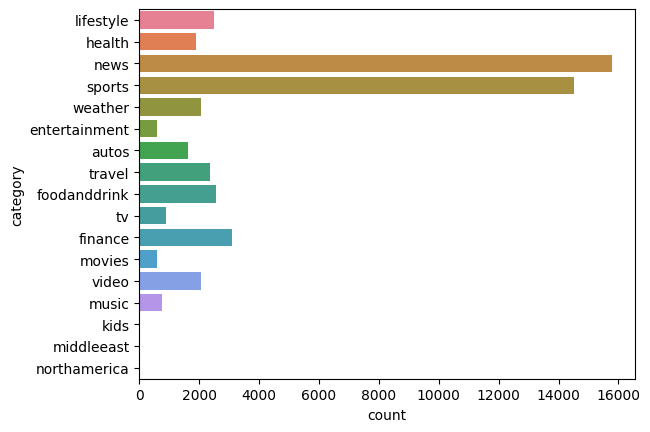

In [4]:
fig = visualization_modules.plot_categories(news)
# Might want to consider sorting so the figure can make better sense, also considering matching colors with the px graph above

Confirming what we saw earlier, news and sports are still our biggest main categories, however new categories not previoulsy seen in our peek such as kids, middleeast and northamerica appear. These latter 3 categories contain so few observations that its unlikely that a user has interacted with them. To ameliorate this, we will see if any users have interacted with articles from these categories and remove the categories depending on the results after we load in the behaviors data.

### Missing Values in News
Before moving on to any further usage of our news dataset, we will check for missing values.

In [5]:
missing_vals = news.isna().sum()
missing_vals

Unnamed: 0              0
news_id                 0
category                0
sub_category            0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

Most missing values are in the abstract with only a few in title_entities and abstract_entities. An abstract briefly summarizes an articles content; by turning abstracts into embeddings we can create a feature that uses similarity of embeddings to recommend news. While we are missing many values we can either remove them or utilize a summarization model like T5 to generate new abstracts for the articles.

## Moving on to Behaviors
The other half of the Microsoft News Dataset is the behaviors file; detailing user interactions, history, and times, the behaviors file provides our recommenders important training data. Due to the inclusion of a timestamp for interactions we examined the temporal context of interactions and created traditional training and testing splits based off of time frames as detailed further below.

In [6]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv')
behaviors.head(2)

,Unnamed: 0,impression_id,user_id,time,history,impressions
0,0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


### Missing values in behaviors
Before showcasing more of our analysis we first discuss the missing values in behaviors.

In [7]:
behaviors.isna().sum()

Unnamed: 0          0
impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

The only column containing missing values is the history column which can have an effect on the efficacy of a sequential recommender. As it is the history column, this implies that there are new users who's first interactions have been logged and have yet to have a history. (look more into history column). This creates a major issue for sequential recommenders, which utilize a users history to create new recommendations. 

When evaluating the Tensorflow sequential recommender, we removed rows that included missing values for history. For other recommender models we added a layer that was able to provide recommendations based off of other features.

### Category Popularity
We then analyzed the popularity of each category and article in the dataset. Each interaction in the dataset has information specific to that interaction: prior history and clickthrough rates for recommended articles. From this, we determined the popularity of articles and categories in regards to, history, clickthrough rate and both. 

In [3]:
category_popularity = pd.read_csv('../MIND_small/csv/category_with_popularity.csv')

In [11]:

# category_popularity.drop(columns=['Unnamed: 0'], inplace=True)
category_popularity_long = category_popularity.melt(id_vars='popularity_type', value_vars=category_popularity.columns, value_name='popularity')
category_popularity_long

# sns.histplot(category_popularity)

# def create_popularity_chart():
#     """ 
#     Maybe here we want to pass in the news and behaviors and then use the create_popularity df so it minimizes boilerplate in the notebook?
#     """
#     pop_long = category_popularity.melt(value_vars=category_popularity.columns, value_name='popularity')
#     news_cat = news['category'].value_counts().to_frame()
#     pop_long.set_index('variable', inplace=True)
#     concatenated = pd.concat([pop_long, news_cat], axis=1)
#     concatenated.reset_index(inplace=True)
#     dat = concatenated.melt(id_vars='index', value_vars=['popularity', 'count']).sort_values(by='value', ascending=False)
#     sns.barplot(data=dat,
#                 y='index',
#                 x='value',
#                 hue='variable')
# create_popularity_chart()
# ## Could also very well re-consider the plot to be something that is only the popularity of categories however could be useful or good to visualize as such


,popularity_type,variable,popularity
0,impressions,lifestyle,26584
1,history,lifestyle,529650
2,impressions,health,10863
3,history,health,230010
4,impressions,news,69408
5,history,news,1603654
6,impressions,sports,28181
7,history,sports,728254
8,impressions,weather,4582
9,history,weather,60410


/Users/nick/miniforge3/envs/recSysEnv/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


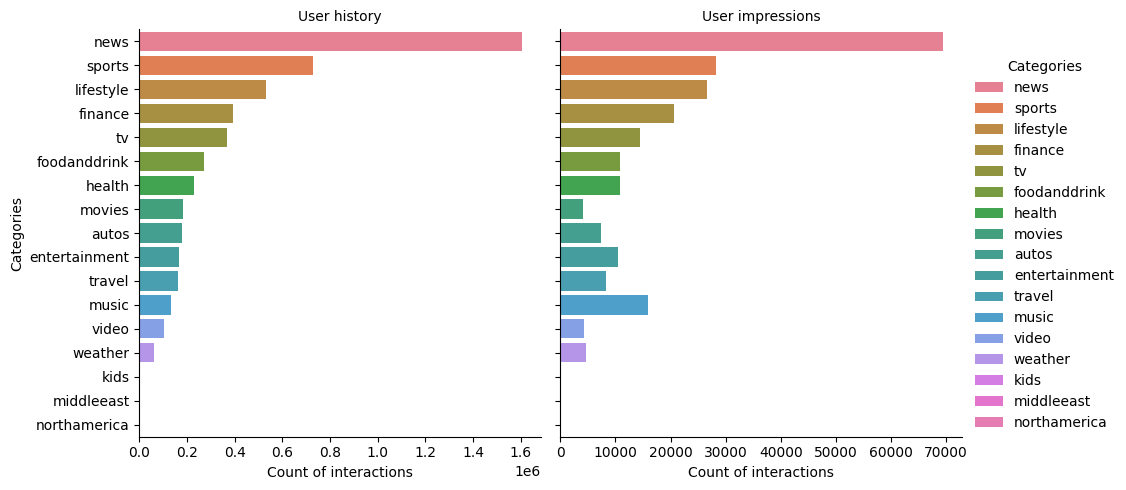

In [28]:
def plot_popularity(category_popularity : pd.DataFrame) -> None:
    """
    Plots category popularity for user impressions and history separately using an SNS FacetGrid.
    
    Args:
        category_popularity (pd.DataFrame) : A pandas dataframe containing the popularity of each category within impressions and user history's.
    
    Returns:
        None
    """
    # Melt and then sort the data.
    category_popularity_long = category_popularity.melt(id_vars='popularity_type', value_vars=category_popularity.columns, value_name='popularity')
    category_popularity_long_sorted = category_popularity_long.sort_values(by=['popularity_type', 'popularity'], ascending=[True, False])
    
    # Create a seaborn FacetGrid for the visualization
    g = sns.FacetGrid(category_popularity_long_sorted, col='popularity_type', sharex=False, height=5, aspect=1, hue='variable')

    # Apply a barplot to each facet and set the labels and titles
    g.map(sns.barplot, 'popularity','variable')
    g.set_axis_labels(x_var="Count of interactions", y_var='Categories')
    g.set_titles("User {col_name}")
    g.add_legend(title='Categories')

    plt.show()

In [16]:
g = sns.catplot(x='variable', y='popularity', hue='popularity_type', data=dfm, kind='bar', height=5, aspect=1)
# plt.figure(figsize=(5, 5))
# ax = sns.barplot(x='class', y='survival rate', hue='sex', data=dfm)
# ax.spines[['top', 'right']].set_visible(False)
# sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
g
# sns.barplot(category_popularity_long, y='variable', x='popularity', hue='popularity_type')

NameError: name 'dfm' is not defined

As visible above, the count of articles in a category does not impact the overall popularity of that category. TV has less articles than weather and yet is much more popular amongst users. It's clear from earlier distribitutions that certain categories have larger catalogs and popularity. To see if category and popularity density affects the quality of recommendations we later experiment with a potential weighting system modeled after IDF with categories that are more prevalent. 

### Addressing the Long Tail
While we are experiementing on density of categories and their popularities, the efficacy of our recommenders could be affected by what is known as the long tail problem; an issue where certain items have a disproportionate number of ratings which can skew recommendations. 

In [ ]:
## Want to use the clean impression function
# Get a dict of all article IDs
# go through all user interactions and determine positive clickthroughs
# might want to check if a click directly refers to history bc if so we can just modify the previous function for popularity slightly
# user history does not get updated with clickthrough rates! uh oh hahahaha, have to change the popularity chart to be representative of history
# and of user click through rates as well

### Accessing temporal aspects of our data
Within our data we have a time column, meaning that we can not only test and train with time in mind, but we can utilize this temporal aspect in our recommendations. As a result of this potential we have access to creating feature interactions based off of an interaction time. 

In [11]:
## Accessing temporal data ##
# how do we go about this? we can bin times into hours by finding the min and max time in the array
# then with our bins we can bin into hours, determining the categories by hours 

# first finding our min and max times
copynews = news.set_index('news_id') # duplicate copynews will have to fix later!
times = [behaviors['time'].max(), behaviors['time'].min()]
# max and then min
# print(times)
# interactions range from the 9th to the 14th, a span of 5 days, want to create bins of 1 hour
# 24 * 5 is 120 hours in total
cut_points = pd.date_range(start='2019-11-09 00:00:00', end='2019-11-15 00:00:00', freq='h') # hourly ranges for the time of the behaviors dataset
# cut_points = np.linspace(start=dataframe[col].min(), stop=dataframe[col].max(), num=5 + 1)
# print(type(cut_points))
behaviors_new = behaviors.copy()
bins_str = cut_points.astype(str).values

labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
print(labels)
behaviors_new['time'] = pd.cut(behaviors['time'], cut_points, labels=labels, include_lowest=True)
# behaviors_new.head()
# might want to use df['toronto_time'] = pd.to_datetime(df['toronto_time']).dt.strftime('%H:%M:%S')
# def get_item_popularity()
# can change the create popularity df function to be applied on every group of time, or a bigger function that takes in a row
# popularity_by_time = behaviors_new.groupby('time').agg()
# df[["col1", "col2", ...]] = df.apply(lambda row: fn(row.text), axis='columns', result_type='expand')
behaviors_new['time'] = behaviors_new['time'].apply(lambda time_string : time_string.split(" ")[-1][:-1])
def clean_impression(impression : str = 'N55689-1') -> dict:
    """ 
    Cleans up a user impression for its characteristics.

    Args:
        impression (str) : A users impression on a recommended article.
    
    Returns:
        impression_info (dict) : A dictionary containing keys for the rating and article in the impression.
    """
    impression_info = impression.split('-')
    return {'score':impression_info[1], 'article_ID':impression_info[0]}    

# func should return a dictionary with column names as keys, we then can group by time, and then sum for each category
# then we can plot with strftime
STANDARD_DICT = {category: 0 for category in pd.unique(copynews['category'])}

def func(row):
    """ 
    Might want to change name from impression to interaction
    """
    user_interactions = row['impressions']
    cols_to_add = STANDARD_DICT.copy()
    if type(user_interactions) != float:
        for impression in user_interactions.split():
            impression_info = clean_impression(impression)
            if impression_info['score'] == '1':
                cols_to_add[copynews.loc[impression_info['article_ID']]['category']] += 1
    return cols_to_add

# print([category_popularity.columns.to_list()])
behaviors_new[category_popularity.columns.to_list()] = behaviors_new.apply(lambda row : func(row), axis='columns', result_type='expand')



# popularity_by_time[[category_popularity.columns]] = popularity_by_time.apply(lambda row : func(row))
# might just want to create a new dataframe with history and time 

['(2019-11-09 00:00:00, 2019-11-09 01:00:00]', '(2019-11-09 01:00:00, 2019-11-09 02:00:00]', '(2019-11-09 02:00:00, 2019-11-09 03:00:00]', '(2019-11-09 03:00:00, 2019-11-09 04:00:00]', '(2019-11-09 04:00:00, 2019-11-09 05:00:00]', '(2019-11-09 05:00:00, 2019-11-09 06:00:00]', '(2019-11-09 06:00:00, 2019-11-09 07:00:00]', '(2019-11-09 07:00:00, 2019-11-09 08:00:00]', '(2019-11-09 08:00:00, 2019-11-09 09:00:00]', '(2019-11-09 09:00:00, 2019-11-09 10:00:00]', '(2019-11-09 10:00:00, 2019-11-09 11:00:00]', '(2019-11-09 11:00:00, 2019-11-09 12:00:00]', '(2019-11-09 12:00:00, 2019-11-09 13:00:00]', '(2019-11-09 13:00:00, 2019-11-09 14:00:00]', '(2019-11-09 14:00:00, 2019-11-09 15:00:00]', '(2019-11-09 15:00:00, 2019-11-09 16:00:00]', '(2019-11-09 16:00:00, 2019-11-09 17:00:00]', '(2019-11-09 17:00:00, 2019-11-09 18:00:00]', '(2019-11-09 18:00:00, 2019-11-09 19:00:00]', '(2019-11-09 19:00:00, 2019-11-09 20:00:00]', '(2019-11-09 20:00:00, 2019-11-09 21:00:00]', '(2019-11-09 21:00:00, 2019-11-09

In [25]:

behaviors_final = behaviors_new.drop(columns=['Unnamed: 0', 'impression_id', 'user_id', 'history', 'impressions'])
                

behaviors_final = behaviors_final.groupby('time').agg('sum')
behaviors_final.reset_index(inplace=True)

/var/folders/83/h9nx83394pb5k_0h4zbb4lw00000gn/T/ipykernel_10514/1544821908.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,time,variable,value
0,0,lifestyle,185
1,1,lifestyle,146
2,2,lifestyle,169
3,3,lifestyle,251
4,4,lifestyle,446
...,...,...,...
403,19,northamerica,1
404,20,northamerica,0
405,21,northamerica,0
406,22,northamerica,0


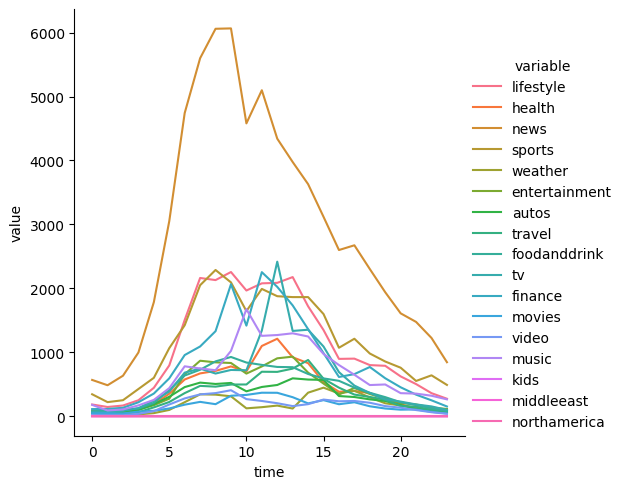

In [52]:


cols = ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']
behaviors_long = behaviors_final.melt(id_vars='time', value_vars=cols)
behaviors_long['time'] = pd.to_datetime(behaviors_long['time'])
behaviors_long['time'] = behaviors_long['time'].dt.hour

sns.relplot(behaviors_long, x='time', y='value', hue='variable', kind='line')
behaviors_long

###  meep
Within the context of a recommender we do not care about the date exactly but more so the hour or time of day, hence we will change the bins accordingly 